# Assignment 1
<!-- Understanding and implementing SLIC Superpixels. -->
A superpixel can be defined as a group of pixels that share common characteristics. Simple Linear Iterative Clustering (SLIC) generates superpixels by clustering pixels based on their color similarity and proximity in the image plane. The purpose of this assignment is to understand and implement SLIC Superpixels.

Some pointers before we start:
- Please follow all submission guidlines which are posted on piazza.
- Ensure all outputs are displayed while rendering the PDF.
- Only modify the code blocks  which has a "TODO".
- Below you can see some outputs for an image of a cow. These images represent the kind of output that is expected. 
- Feel free to reach out to any of the TAs for any doubts/issues.

In [1]:
import sys
sys.path
sys.path.remove("/opt/ros/kinetic/lib/python2.7/dist-packages")

Let's download the dataset first.

In [2]:
!wget http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip

--2020-10-26 21:31:13--  http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.194.120.151, 2600:141b:13:797::e59, 2600:141b:13:7a3::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.194.120.151|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44119839 (42M) [application/octet-stream]
Saving to: ‘msrc_objcategimagedatabase_v1.zip’

msrc_objcategimaged 100%[===================>]  42.08M  3.38MB/s    in 9.0s    

2020-10-26 21:31:22 (4.66 MB/s) - ‘msrc_objcategimagedatabase_v1.zip’ saved [44119839/44119839]



In [3]:
!unzip --qq msrc_objcategimagedatabase_v1.zip

We only focus on six images in this assignment.

In [4]:
im_list = ['MSRC_ObjCategImageDatabase_v1/1_22_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/1_27_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/3_3_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/3_6_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/6_5_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/7_19_s.bmp']

In [5]:
#All important functions to plot, do not modify this block
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.patches as mpatches


def plot_image(im, title, xticks=[], yticks= [], isCv2 = True):
    """
        im: Image to plot
        title: Title of image 
        xticks: List of tick values. Defaults to nothing
        yticks: List of tick values. Defaults to nothing 
        isCv2: Is the image cv2 image? cv2 images are BGR instead of RGB. Default True
    """
    plt.figure()
    if isCv2:
        im = im[:, :, ::-1]
    plt.imshow(im)
    plt.title(title)
    plt.xticks(xticks)
    plt.yticks(yticks)

def superpixel_plot(im, seg, title="Superpixels"):
    """
        Given an image (nXmX3) and pixelwise class mat (nXm), 
        1. Consider each class as a superpixel
        2. Calculate mean superpixel value for each class
        3. Replace the RGB value of each pixel in a class with the mean value  
    
        Inputs:
        im: Input image
        seg: Segmentation map
        title: Title of the plot 
    
        Output: None
        Creates a plot    
    """
    clust = np.unique(seg)
    mapper_dict = {i: im[seg == i].mean(axis = 0)/255. for i in clust}
    
    seg_img =  np.zeros((seg.shape[0], seg.shape[1], 3))
    for i in clust:
        seg_img[seg == i] = mapper_dict[i]
    
    plot_image(seg_img, title)
    return    

def rgb_segment(seg, n=None, plot=True, title=None, legend=True, color=None):
    """
    Given a segmentation map, get the plot of the classes
    """
    clust = np.unique(seg)
    if n is None:
        n = len(clust)
    if color is None:
        cm = plt.cm.get_cmap('hsv', n+1)
        mapper_dict = {i:np.random.rand(3,) for i in clust} 

    seg_img =  np.zeros((seg.shape[0],seg.shape[1],3))
    for i in clust:
        seg_img[seg == i] = mapper_dict[i][:3]

    if plot: 
        plot_image(seg_img,title = title)
    if legend:
        # get the colors of the values, according to the 
        # colormap used by imshow
        patches = [ mpatches.Patch(color=mapper_dict[i], label=" : {l}".format(l=i) ) for i in range(n) ]
        # put those patched as legend-handles into the legend
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
        plt.grid(True)
        plt.show()

    return seg_img

Let's see what the six images are:

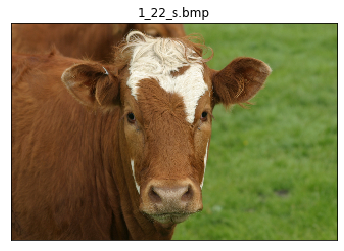

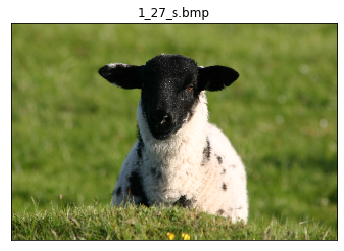

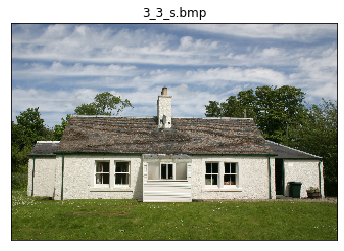

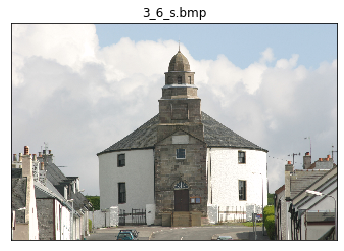

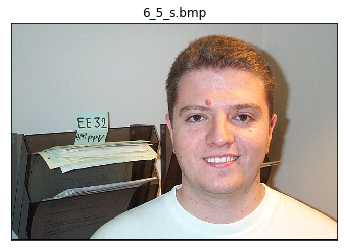

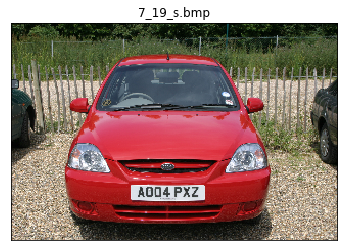

In [6]:
for i in im_list:
    plot_image(cv2.imread(i),i.split("/")[-1])

Get image and visualize it. Its a scenery with 3 elements. You can see the segmentation ground truth in the GT bitmap.  

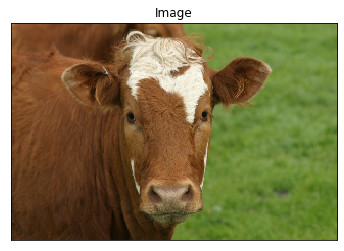

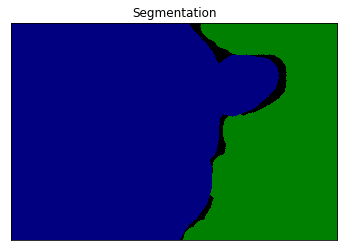

In [7]:
im = cv2.imread(im_list[0])
seg = cv2.imread(im_list[0].replace("_s","_s_GT"))

plot_image(im,"Image")
plot_image(seg,"Segmentation")

###Question 1: K-means on RGB
We know k-means clustering algorithm. It is an unsupervised algorithm which minimizes **the within-cluster sum of squares(WCSS).  

Complete the pixel clustering function. It should take input an image (dim = (n $\times$ m  $\times$ 3)) and number of clusters needed. 
Does K means clustering work on image pixels?
Let the number of clusters be K = 5, 10, 50

In [86]:
# KMeans algo
def k_means_algo(k, samples):
    """
        Inputs:
        k: the number of clusters
        samples: the input datapoints
        
        Output:
        cluster_labels: the cluster number for each sample
    """
    # choose initial clusters according to kmeans++ paper
    kcentroids = np.array([random.choice(samples)])
    while len(kcentroids) < k:
        # compute D(x)
        distance = np.ones(len(samples))*10000000000
        for i in range(0, len(kcentroids)):
            distance = np.vstack((distance, np.linalg.norm(samples-kcentroids[i], axis=1)))
        distance = np.min(distance, axis=0)
        
        # pick next center randomly with weighted probability
        kcentroids = np.vstack((kcentroids, random.choices(samples, distance)[0]))
    
    # run k-means
    iter = 5000
    curr_iter = 1
    hash_clusters = {}
    cluster_labels = np.array([])
    while curr_iter < iter:
        curr_iter += 1
        
        cluster_labels = np.array([])
        distance = np.ones(len(samples))*10000000000
        for i in range(0, k):
            distance = np.vstack((distance, np.linalg.norm(samples-kcentroids[i], axis=1)))
        distance = distance[1:]
        cluster_labels = np.argmin(distance, axis=0)
        
        kcentroids = np.array([])
        for i in range(0, k):
            indices_i = np.where(cluster_labels==i)
            new_centroid_i = np.sum(samples[indices_i], axis=0)/len(indices)
            
            if(len(kcentroids) == 0):
                kcentroids = np.array([new_centroid_i])
            else:
                kcentroids = np.vstack((kcentroids, new_centroid_i))
    
    # return cluster number for each sample
    return cluster_labels

In [ ]:
from sklearn.cluster import KMeans
import numpy as  np


def cluster_pixels(im, k):    
    """
    Inputs: 
        im: the input image of shape (n, m, 3)
        k: the number of clusters
    
    Output:
        segmap: the output shape of (n, m) where each entry is the cluster index it belongs to
    """
    image = []
    for row in range(0, im.shape[0]):
        for col in range(0, im.shape[1]):
            image.append([im[row, col, 0], im[row, col, 1], im[row, col, 2]])
    segmap = k_means_algo(k, np.array(image))
    segmap = np.array(segmap)
    segmap = segmap.reshape(im.shape[0], im.shape[1])
    return segmap

for k in [5, 10, 50]:
    clusters = cluster_pixels(im, k)
    _ = rgb_segment(clusters, n=k, title="naive clustering: Pixelwise class plot: Clusters: " + str(k),legend = False)
    superpixel_plot(im, clusters, title =  "naive clustering: Superpixel plot: Clusters: "+ str(k))

###Question 2: Now that you have a function handy, we have a slightly complex task

Instead of making clustering run on RGB space, run the clustering on RGBXY space. What advantages does that give us? 
(try with clusters = 5, 10, 25, 50, 150)

Answer: The advantages this approach might give is that instead of just considering the color distance, we are also taking into account the pixel proximity, i.e how near the pixels are to each other.

In [ ]:
#TODO: clustering r,b,g,x,y values 
#try k = 20,80,200,400,800

def cluster_rgbxy(im, k):
    """
    Inputs: 
        im: the input image of shape (n, m, 3)
        k: the number of clusters
    
    Output:
        segmap: the output shape of (n, m) where each entry is the cluster index it belongs to
    """
    image = []
    for row in range(0, im.shape[0]):
        for col in range(0, im.shape[1]):
            image.append((im[row, col, 0], im[row, col, 1], im[row, col, 2], row, col))
    segmap = k_means_algo(k, np.array(image))
    segmap = np.array(segmap)
    segmap = segmap.reshape(im.shape[0], im.shape[1])
    return segmap

for k in [5, 10, 20, 50, 80, 150, 200, 400, 800]:
    clusters = cluster_rgbxy(im, k)
    _ = rgb_segment(clusters, n=k, title="naive clustering: Pixelwise class plot: Clusters: " + str(k), legend=False)
    superpixel_plot(im, clusters, title="naive clustering: Superpixel plot: Clusters: "+ str(k))

###  Modified k-means with weighted distances. 

 Let $cluster\_center_i$ represent $i^{th}$ cluster center, $cluster\_center_i^{rgb}$ denote the RGB value and $cluster\_center_i^{xy}$ be the corresponding coordinate of the center pixel, respectively.
 
 Let $x_{rgb}$ be the the RGB value of a pixel, and let $x_{xy}$ be the corresponding pixel's coordinate.
 <!-- Let $x_{xy}$ be the coordinate of $x_{rgb}$ -->

$distance(x_{rgb},x_{xy}) = \lambda_1 * euclidean(x_{rgb},cluster\_center_{i}^{rgb})  + \lambda_2 * euclidean(x_{xy},cluster\_center_{i}^{xy})$



Find good values for hyperparmeters $\lambda_1$ and $\lambda_2$ (try on 250 clusters)

In [ ]:
#TODO: clustering r,b,g,x,y values with lambdas and display outputs
def cluster_rgbxy(im, k, lambda_1, lambda_2):
    """
    Inputs: 
        im: the input image of shape (n, m, 3)
        k: the number of clusters
        lambda_1: the weight value for rgb channels
        lambda_2: the weight value for xy
    Output:
        segmap: the output shape of (n, m) where each entry is the cluster index it belongs to
    """
    image = []
    for row in range(0, im.shape[0]):
        for col in range(0, im.shape[1]):
            image.append((im[row, col, 0], im[row, col, 1], im[row, col, 2], row, col))
    clusters = KMeans(n_clusters=k).fit(image, sample_weight=[lambda_1, lambda_1, lambda_1, lambda_2, lambda_2])
    segmap = clusters.labels_.reshape(im.shape[0], im.shape[1])
    return segmap

for k in [5]:
    clusters = cluster_rgbxy(im, k)
    _ = rgb_segment(clusters, n=k, title="naive clustering: Pixelwise class plot: Clusters: " + str(k), legend=False)
    superpixel_plot(im, clusters, title="naive clustering: Superpixel plot: Clusters: "+ str(k))

###Question 3: SLIC

It doesn't look like we have a very favourable outcome with superpixels simply being implemented as K-means. Can we do better? Have a look at the SLIC paper [here](https://www.iro.umontreal.ca/~mignotte/IFT6150/Articles/SLIC_Superpixels.pdf). Incorporate S and m and redefine your distance metric as per the paper.


In [ ]:
#TODO
############Algorithm############
#Compute grid steps: S
#you can explore different values of m
#initialize cluster centers [l,a,b,x,y] using  
#Perturb for minimum G
#while not converged
##for every pixel:
####  compare distance D_s with each cluster center within 2S X 2S. 
####  Assign to nearest cluster
##calculate new cluster center 
 

def SLIC(im, k):
    """
    Input 
        im: image input
        k: number of cluster segments

        Compute
        S: As described in the paper
        m: As described in the paper (use the same value as in the paper) follow the algorithm..
    
    Output
        segmap: 2D matrix where each value corresponds to the image pixel's cluster number
    """
    
    return segmap

In [ ]:
#TODO diplay your SLIC results.
for k in [5]:
    clusters = SLIC(im, k)
    _ = rgb_segment(clusters, n=k, title="naive clustering: Pixelwise class plot: Clusters: " + str(k), legend=False)
    superpixel_plot(im, clusters, title="naive clustering: Superpixel plot: Clusters: " + str(k))

## Bonus Question:
Enforce connectivity: There are many superpixels which are very small and disconnected from each other. Try to merge them with larger superpixels

O(N) algorithm:
1. Set a minimum size of superpixel
2. If the area of a region is smaller than a threshold, we assign it to the nearest cluster 


In [ ]:
#TODO
sdaddsadaddsadasdassdadadsadasxxssssssssssssssssssssssss



## Your File
Link to your colab/ipynb file: **Insert google drive/colab link here**
